# NESTS algorithm **Kopuru Vespa Velutina Competition**

Purpose: Bring together weather data, geographic data, food availability data, and identified nests in each municipality of Biscay in order to have a dataset suitable for analysis and potential predictions in a Machine Learning model.

Outputs: QUEENtrain and QUEENpredict datasets *(WBds03_QUEENtrain.csv & WBds03_QUEENpredict.csv)*

@authors:
* mario.bejar@student.ie.edu
* pedro.geirinhas@student.ie.edu
* a.berrizbeitia@student.ie.edu
* pcasaverde@student.ie.edu

## Libraries

In [1]:
import pandas as pd
import numpy as np
import math
from plotnine import *

In [2]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn import preprocessing

## Get the data

In [3]:
df01 = pd.read_csv('../../../Input_open_data/ds01_PLANTILLA-RETO-AVISPAS-KOPURU.csv', sep=";")
df02 = pd.read_csv('../../../Input_open_data/ds02_datos-nidos-avispa-asiatica.csv', sep=",")
df03 = pd.read_csv('../../../Input_open_data/ds03_APICULTURA_COLMENAS_KOPURU.csv', sep=";")
df04 = pd.read_csv('../../../Input_open_data/ds04_FRUTALES-DECLARADOS-KOPURU.csv', sep=";")
WBdf01 = pd.read_csv('./WBds01_GEO.csv', sep=',')
WBdf02 = pd.read_csv('./WBds02_METEO.csv', sep=',')
df_population = pd.read_csv('../../../Other_open_data/population.csv', sep=',')

## Data cleanup

### Getting the names right

In [4]:
# Dropping and Renaming columns in accordance to the DataMap
# DataMap's URL: https://docs.google.com/spreadsheets/d/1Ad7s4IOmj9Tn2WcEOz4ArwedTzDs9Y0_EaUSm6uRHMQ/edit#gid=0

df01.columns = ['municip_code', 'municip_name', 'nests_2020']
df01.drop(columns=['nests_2020'], inplace=True) # just note that this is the final variable to predict in the competition

df02.drop(columns=['JARDUERA_ZENBAKIA/NUM_ACTUACION', 'ERABILTZAILEA_EU/USUARIO_EU', 'ERABILTZAILEA_CAS/USUARIO_CAS', 'HELBIDEA/DIRECCION', 'EGOERA_EU/ESTADO_EU', 'ITXIERA_DATA/FECHA CIERRE', 'ITXIERAKO AGENTEA_EU/AGENTE CIERRE_EU', 'ITXIERAKO AGENTEA_CAS/AGENTE CIERRE_CAS'], inplace=True)
df02.columns = ['waspbust_id', 'year', 'nest_foundDate', 'municip_name', 'species', 'nest_locType', 'nest_hight', 'nest_diameter', 'nest_longitude', 'nest_latitude', 'nest_status']

df03.drop(columns=['CP'], inplace=True)
df03.columns = ['municip_name','municip_code','colonies_amount']

df04.columns = ['agriculture_type','municip_code','municip_name']

In [5]:
# We don't have the "months" specified for any of the records in 2017 ('nest_foundDate' is incorrect for this year), so we'll drop those records
df02 = df02.drop(df02[df02['year'] == 2017].index, inplace = False)

In [6]:
# Cleaning municipality names in ds02 with names from ds01
df02_wrong_mun = ['ABADIÑO' ,'ABANTO Y CIERVANA' ,'ABANTO Y CIERVANA-ABANTO ZIERBENA' ,'AJANGIZ' ,'ALONSOTEGI' ,'AMOREBIETA-ETXANO' ,'AMOROTO' ,'ARAKALDO' ,'ARANTZAZU' ,'AREATZA' ,'ARRANKUDIAGA' ,'ARRATZU' ,'ARRIETA' ,'ARRIGORRIAGA' ,'ARTEA' ,'ARTZENTALES' ,'ATXONDO' ,'AULESTI' ,'BAKIO' ,'BALMASEDA' ,'BARAKALDO' ,'BARRIKA' ,'BASAURI' ,'BEDIA' ,'BERANGO' ,'BERMEO' ,'BERRIATUA' ,'BERRIZ' ,'BUSTURIA' ,'DERIO' ,'DIMA' ,'DURANGO' ,'EA' ,'ELANTXOBE' ,'ELORRIO' ,'ERANDIO' ,'EREÑO' ,'ERMUA' ,'ERRIGOITI' ,'ETXEBARRI' ,'ETXEBARRIA', 'ETXEBARRIa','FORUA' ,'FRUIZ' ,'GALDAKAO' ,'GALDAMES' ,'GAMIZ-FIKA' ,'GARAI' ,'GATIKA' ,'GAUTEGIZ ARTEAGA' ,'GERNIKA-LUMO' ,'GETXO' ,'GETXO ' ,'GIZABURUAGA' ,'GORDEXOLA' ,'GORLIZ' ,'GUEÑES' ,'IBARRANGELU' ,'IGORRE' ,'ISPASTER' ,'IURRETA' ,'IZURTZA' ,'KARRANTZA HARANA/VALLE DE CARRANZA' ,'KARRANTZA HARANA-VALLE DE CARRANZA' ,'KORTEZUBI' ,'LANESTOSA' ,'LARRABETZU' ,'LAUKIZ' ,'LEIOA' ,'LEKEITIO' ,'LEMOA' ,'LEMOIZ' ,'LEZAMA' ,'LOIU' ,'MALLABIA' ,'MAÑARIA' ,'MARKINA-XEMEIN' ,'MARURI-JATABE' ,'MEÑAKA' ,'MENDATA' ,'MENDEXA' ,'MORGA' ,'MUNDAKA' ,'MUNGIA' ,'MUNITIBAR-ARBATZEGI' ,'MUNITIBAR-ARBATZEGI GERRIKAITZ' ,'MURUETA' ,'MUSKIZ' ,'MUXIKA' ,'NABARNIZ' ,'ONDARROA' ,'OROZKO' ,'ORTUELLA' ,'OTXANDIO' ,'PLENTZIA' ,'PORTUGALETE' ,'SANTURTZI' ,'SESTAO' ,'SONDIKA' ,'SOPELA' ,'SOPUERTA' ,'SUKARRIETA' ,'TRUCIOS-TURTZIOZ' ,'UBIDE' ,'UGAO-MIRABALLES' ,'URDULIZ' ,'URDUÑA/ORDUÑA' ,'URDUÑA-ORDUÑA' ,'VALLE DE TRAPAGA' ,'VALLE DE TRAPAGA-TRAPAGARAN' ,'ZALDIBAR' ,'ZALLA' ,'ZAMUDIO' ,'ZARATAMO' ,'ZEANURI' ,'ZEBERIO' ,'ZIERBENA' ,'ZIORTZA-BOLIBAR' ]
df02_correct_mun = ['Abadiño' ,'Abanto y Ciérvana-Abanto Zierbena' ,'Abanto y Ciérvana-Abanto Zierbena' ,'Ajangiz' ,'Alonsotegi' ,'Amorebieta-Etxano' ,'Amoroto' ,'Arakaldo' ,'Arantzazu' ,'Areatza' ,'Arrankudiaga' ,'Arratzu' ,'Arrieta' ,'Arrigorriaga' ,'Artea' ,'Artzentales' ,'Atxondo' ,'Aulesti' ,'Bakio' ,'Balmaseda' ,'Barakaldo' ,'Barrika' ,'Basauri' ,'Bedia' ,'Berango' ,'Bermeo' ,'Berriatua' ,'Berriz' ,'Busturia' ,'Derio' ,'Dima' ,'Durango' ,'Ea' ,'Elantxobe' ,'Elorrio' ,'Erandio' ,'Ereño' ,'Ermua' ,'Errigoiti' ,'Etxebarri' , 'Etxebarria', 'Etxebarria','Forua' ,'Fruiz' ,'Galdakao' ,'Galdames' ,'Gamiz-Fika' ,'Garai' ,'Gatika' ,'Gautegiz Arteaga' ,'Gernika-Lumo' ,'Getxo' ,'Getxo' ,'Gizaburuaga' ,'Gordexola' ,'Gorliz' ,'Güeñes' ,'Ibarrangelu' ,'Igorre' ,'Ispaster' ,'Iurreta' ,'Izurtza' ,'Karrantza Harana/Valle de Carranza' ,'Karrantza Harana/Valle de Carranza' ,'Kortezubi' ,'Lanestosa' ,'Larrabetzu' ,'Laukiz' ,'Leioa' ,'Lekeitio' ,'Lemoa' ,'Lemoiz' ,'Lezama' ,'Loiu' ,'Mallabia' ,'Mañaria' ,'Markina-Xemein' ,'Maruri-Jatabe' ,'Meñaka' ,'Mendata' ,'Mendexa' ,'Morga' ,'Mundaka' ,'Mungia' ,'Munitibar-Arbatzegi Gerrikaitz' ,'Munitibar-Arbatzegi Gerrikaitz' ,'Murueta' ,'Muskiz' ,'Muxika' ,'Nabarniz' ,'Ondarroa' ,'Orozko' ,'Ortuella' ,'Otxandio' ,'Plentzia' ,'Portugalete' ,'Santurtzi' ,'Sestao' ,'Sondika' ,'Sopela' ,'Sopuerta' ,'Sukarrieta' ,'Trucios-Turtzioz' ,'Ubide' ,'Ugao-Miraballes' ,'Urduliz' ,'Urduña/Orduña' ,'Urduña/Orduña' ,'Valle de Trápaga-Trapagaran' ,'Valle de Trápaga-Trapagaran' ,'Zaldibar' ,'Zalla' ,'Zamudio' ,'Zaratamo' ,'Zeanuri' ,'Zeberio' ,'Zierbena' ,'Ziortza-Bolibar',]
df02.municip_name.replace(to_replace = df02_wrong_mun, value = df02_correct_mun, inplace = True)
df02.shape

(6682, 11)

In [7]:
# Translate the `species` variable contents to English
df02.species.replace(to_replace=['AVISPA ASIÁTICA', 'AVISPA COMÚN', 'ABEJA'], value=['Vespa Velutina', 'Common Wasp', 'Wild Bee'], inplace=True)

In [8]:
# Translate the contents of the `nest_locType` and `nest_status` variables to English
# But note that this data makes is of no use from a "forecastoing" standpoint eventually, since we will predict with a one-year offset (and thus, use thigs like weather mostly)

df02.nest_locType.replace(to_replace=['CONSTRUCCIÓN', 'ARBOLADO'], value=['Urban Environment', 'Natural Environment'], inplace=True)
df02.nest_status.replace(to_replace=['CERRADA - ELIMINADO', 'CERRADA - NO ELIMINABLE', 'PENDIENTE DE GRUPO'], value=['Nest Terminated', 'Cannot Terminate', 'Pending classification'], inplace=True)

### Getting the dates right
Including the addition of a `year_offset` variable to comply with the competition's rules

In [9]:
# Changing 'nest_foundDate' the to "datetime" format
df02['nest_foundDate'] = pd.to_datetime(df02['nest_foundDate'])

# Create a "month" variable in the main dataframe
df02['month'] = pd.DatetimeIndex(df02['nest_foundDate']).month

# Create a "year_offset" variable in the main dataframe
# IMPORTANT: THIS REFLECTS OUR ASSUMPTION THAT `YEAR-1` DATA CAN BE USE TO PREDICT `YEAR` DATA, AS MANDATED BY THE COMPETITION'S BASE REQUIREMENTS
df02['year_offset'] = pd.DatetimeIndex(df02['nest_foundDate']).year - 1

In [10]:
df02.columns

Index(['waspbust_id', 'year', 'nest_foundDate', 'municip_name', 'species',
       'nest_locType', 'nest_hight', 'nest_diameter', 'nest_longitude',
       'nest_latitude', 'nest_status', 'month', 'year_offset'],
      dtype='object')

### Creating distinct dataFrames for each `species`

In [11]:
df02.species.value_counts()

Vespa Velutina    6042
Common Wasp        274
Wild Bee           145
Name: species, dtype: int64

In [12]:
df02_vespas = df02.loc[df02.species == 'Vespa Velutina', :]
df02_wasps = df02.loc[df02.species == 'Common Wasp', :]
df02_bees = df02.loc[df02.species == 'Wild Bee', :]

In [13]:
df02_vespas.shape

(6042, 13)

## Create a TEMPLATE dataframe with the missing municipalities and months

In [14]:
template = pd.read_csv('../../../Input_open_data/ds01_PLANTILLA-RETO-AVISPAS-KOPURU.csv', sep=";")
template.drop(columns='NIDOS 2020', inplace=True)
template.columns = ['municip_code', 'municip_name']
template['year2019'] = 2019
template['year2018'] = 2018
template['year2017'] = 2017
template = pd.melt(template, id_vars=['municip_code', 'municip_name'], value_vars=['year2019', 'year2018', 'year2017'], value_name = 'year_offset')
template.drop(columns='variable', inplace=True)

In [15]:
for i in range(1,13,1):
    template[i] = i
template = pd.melt(template, id_vars=['municip_code', 'municip_name', 'year_offset'],\
                   value_vars=[1,2,3,4,5,6,7,8,9,10,11,12], value_name = 'month')
template.drop(columns='variable', inplace=True)

In [16]:
template.shape

(4032, 4)

In [17]:
112*12*3 == template.shape[0]

True

In [18]:
template.columns

Index(['municip_code', 'municip_name', 'year_offset', 'month'], dtype='object')

In [19]:
df02_vespas.shape[0] - template.shape[0]

2010

## Merge the datasets

### Match each `municip_name` to its `municip_code` as per the competition's official template (i.e. `df01`)

In [20]:
# Merge dataFrames df01 and df02 by 'municip_name', in order to identify every wasp nest with its 'municip_code'
# The intention is that 'all_the_queens-wasps' will be the final dataFrame to use in the ML model eventually

all_the_queens_wasps = pd.merge(df02_vespas, df01, how = 'left', on = 'municip_name')

In [21]:
# check if there are any municipalities missing from the df02 dataframe, and add them if necessary

df01.municip_code[~df01.municip_code.isin(all_the_queens_wasps.municip_code.unique())]

27    48020
Name: municip_code, dtype: int64

### Input municipalities and months missing from the dataset

In [22]:
all_the_queens_wasps = pd.merge(all_the_queens_wasps, template,\
                                      how = 'outer', left_on = ['municip_code', 'municip_name', 'year_offset', 'month'],\
                                      right_on = ['municip_code', 'municip_name', 'year_offset', 'month'])

In [23]:
all_the_queens_wasps.isnull().sum()

waspbust_id       2394
year              2394
nest_foundDate    2394
municip_name         0
species           2394
nest_locType      2565
nest_hight        2394
nest_diameter     2394
nest_longitude    3298
nest_latitude     3298
nest_status       2394
month                0
year_offset          0
municip_code         0
dtype: int64

In [24]:
all_the_queens_wasps.year.fillna(value='no registers', inplace=True)

In [25]:
all_the_queens_wasps.shape

(8436, 14)

### Discarding some variables

In [26]:
all_the_queens_wasps.drop(columns=['nest_foundDate', 'nest_longitude', 'nest_latitude', 'species'], inplace=True)

### Creating a new categorical variable for Nest Size
**THIS WAS LEFT PENDING, SINCE THE OUTLIERS ARE BOTHERSOME**

[Formula for nest volume](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6723431/)

[Example calculation in cubic meters](https://www.easycalculation.com/shapes/volume-of-prolate-spheroid.php)

In [27]:
all_the_queens_wasps['nest_volume_l'] = 4/3 * math.pi * (all_the_queens_wasps['nest_hight']/100/2)**2 * (all_the_queens_wasps['nest_diameter']/100/2) * 1000
all_the_queens_wasps['nest_volume_l'].fillna(0, inplace=True)

In [28]:
all_the_queens_wasps['nest_volume_l'].describe()

count    8436.000000
mean        3.647638
std        99.007358
min         0.000000
25%         0.000000
50%         0.047124
75%         1.047198
max      8344.855486
Name: nest_volume_l, dtype: float64

C:\Users\alebe\anaconda3\lib\site-packages\plotnine\layer.py:401: PlotnineWarning: geom_point : Removed 2394 rows containing missing values.


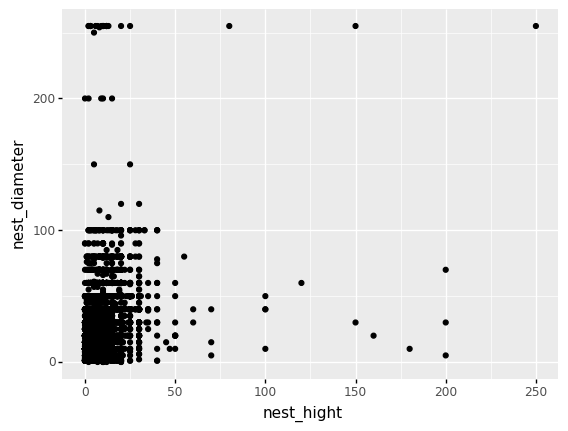

<ggplot: (190968629179)>

In [29]:
ggplot(aes(x='nest_hight', y='nest_diameter'), all_the_queens_wasps) + geom_point(stat='identity')

In [30]:
all_the_queens_wasps['nest_volume_l'] = pd.cut(all_the_queens_wasps['nest_volume_l'], bins=3, labels=['small', 'mid', 'large'])

In [31]:
#all_the_queens_wasps.drop(columns=['nest_hight', 'nest_diameter', 'nest_volume_l'], inplace=True)
# THIS CELL SHOULD BE DELETED IN A FUTURE ITERATION

### Converting categoricals to dummy variables

In [32]:
queen_volume = pd.get_dummies(all_the_queens_wasps.nest_volume_l)
all_the_queens_wasps = pd.concat([all_the_queens_wasps, queen_volume], axis=1)

queen_urban = pd.get_dummies(all_the_queens_wasps.nest_locType)
all_the_queens_wasps = pd.concat([all_the_queens_wasps, queen_urban], axis=1)

queen_hastalavista = pd.get_dummies(all_the_queens_wasps.nest_status)
all_the_queens_wasps = pd.concat([all_the_queens_wasps, queen_hastalavista], axis=1)

all_the_queens_wasps.drop(columns=['nest_locType', 'nest_hight', 'nest_diameter', 'nest_volume_l', 'nest_status'], inplace=True)

all_the_queens_wasps.rename(columns = {"small":"fv_size_small", "mid":"fv_size_mid", "large":"fv_size_large",\
                                      "Natural Environment":"fv_type_natural", "Urban Environment":"fv_type_urban",\
                                      "Cannot Terminate":"fv_status_cantkill", "Nest Terminated":"fv_status_dead", "Pending classification":"fv_status_pending"}, inplace = True)

#all_the_queens_wasps

In [33]:
all_the_queens_wasps.isnull().sum()

waspbust_id           2394
year                     0
municip_name             0
month                    0
year_offset              0
municip_code             0
fv_size_small            0
fv_size_mid              0
fv_size_large            0
fv_type_natural          0
fv_type_urban            0
fv_status_cantkill       0
fv_status_dead           0
fv_status_pending        0
dtype: int64

### Counting the amount of wasp nests in each municipality, for each month and year
... and dropping some variables along the way.
Namely: **species** (keeping the Vespa Velutina only), **nest_foundDate**, **nest_locType**, **nest_hight**, **nest_diameter**, **nest_longitude**, **nest_latitude**, **nest_status**

In [34]:
# Filtering the rest of variables now, and counting
all_the_queens_wasps = all_the_queens_wasps.loc[:, ['waspbust_id', 'fv_size_small', 'fv_size_mid', 'fv_size_large', 'fv_type_natural', 'fv_type_urban',\
                                                    'fv_status_cantkill', 'fv_status_dead', 'fv_status_pending', 'year', 'municip_name', 'municip_code', 'month', 'year_offset']]\
.groupby(by =['year', 'municip_name', 'municip_code', 'month', 'year_offset'], as_index = False).count()

In [35]:
# let's rename the id to NESTS, now that it has been counted
all_the_queens_wasps.rename(columns = {"waspbust_id":"NESTS"}, inplace = True)

In [36]:
all_the_queens_wasps.columns

Index(['year', 'municip_name', 'municip_code', 'month', 'year_offset', 'NESTS',
       'fv_size_small', 'fv_size_mid', 'fv_size_large', 'fv_type_natural',
       'fv_type_urban', 'fv_status_cantkill', 'fv_status_dead',
       'fv_status_pending'],
      dtype='object')

In [37]:
# verifying that the DataFrame has the right number of rows
all_the_queens_wasps.shape[0] == 112*12*3

True

In [38]:
all_the_queens_wasps.NESTS.sum() == df02_vespas.shape[0]

True

In [39]:
# for all those "outer merge" rows with no associated year, set their NESTS to zero
all_the_queens_wasps.loc[all_the_queens_wasps.year == 'no registers', ['NESTS']] = 0

In [40]:
all_the_queens_wasps.NESTS.sum() == df02_vespas.shape[0]

True

In [41]:
all_the_queens_wasps.isnull().sum()

year                  0
municip_name          0
municip_code          0
month                 0
year_offset           0
NESTS                 0
fv_size_small         0
fv_size_mid           0
fv_size_large         0
fv_type_natural       0
fv_type_urban         0
fv_status_cantkill    0
fv_status_dead        0
fv_status_pending     0
dtype: int64

### Food sources

In [42]:
# Group df03 by 'municip_code' because there are multiple rows for each municipality (and we need a 1:1 relationship)
df03 = df03.groupby(by = 'municip_code', as_index= False).colonies_amount.sum()

In [43]:
# Now merge df03 to add number of bee hives (which is a food source for the wasp) in each municipality
# Note that NaNs (unknown amount of hives) are replaced with zeroes for the 'colonies_amount' variable

all_the_queens_wasps = pd.merge(all_the_queens_wasps, df03, how = 'left', on = 'municip_code')
all_the_queens_wasps.colonies_amount.fillna(value=0, inplace=True)

In [44]:
all_the_queens_wasps.shape

(4032, 15)

In [45]:
#all_the_queens_wasps.isnull().sum()

In [46]:
# Group df04 (agricultural food sources) by municipality code, after appending variables with the amount of each type of agricultural product

aux = df04.copy(deep=True)
aux.drop(columns=['municip_name'], inplace=True)

aux['food_fruit'] = np.where(aux['agriculture_type'] == 'FRUTALES', '1', '0')
aux['food_fruit'] = aux['food_fruit'].astype('int')

aux['food_apple'] = np.where(aux['agriculture_type'] == 'MANZANO', '1', '0')
aux['food_apple'] = aux['food_apple'].astype('int')

txakoli_string = df04.agriculture_type[45]
aux['food_txakoli'] = np.where(aux['agriculture_type'] == txakoli_string, '1', '0')
aux['food_txakoli'] = aux['food_txakoli'].astype('int')

aux['food_kiwi'] = np.where(aux['agriculture_type'] == 'AKTINIDIA (KIWI)', '1', '0')
aux['food_kiwi'] = aux['food_kiwi'].astype('int')

aux['food_pear'] = np.where(aux['agriculture_type'] == 'PERAL', '1', '0')
aux['food_pear'] = aux['food_pear'].astype('int')

aux['food_blueberry'] = np.where(aux['agriculture_type'] == 'ARANDANOS', '1', '0')
aux['food_blueberry'] = aux['food_blueberry'].astype('int')

aux['food_raspberry'] = np.where(aux['agriculture_type'] == 'FRAMBUESAS', '1', '0')
aux['food_raspberry'] = aux['food_raspberry'].astype('int')

aux = aux.groupby(by='municip_code', as_index=False).sum()
df04 = aux.copy(deep=True)

In [47]:
# Now merge df04 to add number of each type of food source ('agriculture_type') present in each municipality
# Any municipality not present in df04 will get assigned 'zero' food sources for any given type of fruit

all_the_queens_wasps = pd.merge(all_the_queens_wasps, df04, how = 'left', on= 'municip_code')
all_the_queens_wasps.food_fruit.fillna(value=0, inplace=True)
all_the_queens_wasps.food_apple.fillna(value=0, inplace=True)
all_the_queens_wasps.food_txakoli.fillna(value=0, inplace=True)
all_the_queens_wasps.food_kiwi.fillna(value=0, inplace=True)
all_the_queens_wasps.food_pear.fillna(value=0, inplace=True)
all_the_queens_wasps.food_blueberry.fillna(value=0, inplace=True)
all_the_queens_wasps.food_raspberry.fillna(value=0, inplace=True)

In [48]:
all_the_queens_wasps.shape

(4032, 22)

In [49]:
#all_the_queens_wasps.isnull().sum()

### Geographic
Here, a very important assumption regarding which station corresponds to each municipality is being brought from the HONEYCOMB script

In [50]:
# Adding weather station code to each municipality in all_the_queens_wasps. "No municipality left behind!"
all_the_queens_wasps = pd.merge(all_the_queens_wasps, WBdf01, how = 'left', on= 'municip_code')

In [51]:
all_the_queens_wasps.shape

(4032, 23)

In [52]:
#all_the_queens_wasps.isnull().sum()

In [53]:
all_the_queens_wasps.year_offset.value_counts()

2018    1344
2017    1344
2019    1344
Name: year_offset, dtype: int64

### Weather

MANDATORY ASSUMPTION: As per the competition's rules. 2020 weather data cannot be used to predict 2020's number of wasp nests.

Therefore, **this merge links 2018's wasp nests to 2017's weather data for each corresponding month** (all of which falls under the $2017$ value for `year_offset`).

Likewise, **2019's wasp nests are linked to 2018's weather data for the corresponding month** (all of which falls under the $2018$ value for `year_offset`).

Finally, the $2019$ value for `year_offset` contains zero NESTS and the year 2019's weather which we will use to predict 2020's number of NESTS (the target variable of the competition)

In [54]:
# Now, merge the Main 'all_the_queens_wasps' dataFrame with the weather data 'WBdf02' dataFrame
all_the_queens_wasps = pd.merge(all_the_queens_wasps, WBdf02, how = 'left',\
                                      left_on = ['station_code', 'month', 'year_offset'],\
                                      right_on = ['station_code', 'month', 'year'])

In [55]:
# note that this relabels `year` from the `all_the_queens_wasps` dataframe as `year_x`, and likewise as `year_y` from the WBdf02 dataframe
all_the_queens_wasps.columns

Index(['year_x', 'municip_name', 'municip_code', 'month', 'year_offset',
       'NESTS', 'fv_size_small', 'fv_size_mid', 'fv_size_large',
       'fv_type_natural', 'fv_type_urban', 'fv_status_cantkill',
       'fv_status_dead', 'fv_status_pending', 'colonies_amount', 'food_fruit',
       'food_apple', 'food_txakoli', 'food_kiwi', 'food_pear',
       'food_blueberry', 'food_raspberry', 'station_code', 'index', 'MMM',
       'year_y', 'station_name', 'code_merge', 'merge_cod', 'weath_days_frost',
       'weath_humidity', 'weath_maxLevel', 'weath_midLevel', 'weath_minLevel',
       'weath_days_rain', 'weath_days_rain1mm', 'weath_accuRainfall',
       'weath_10minRainfall', 'weath_1dayRainfall', 'weath_solar',
       'weath_meanTemp', 'weath_maxTemp', 'weath_maxMeanTemp', 'weath_minTemp',
       'weath_meanWindM', 'weath_maxWindM', 'weath_meanDayMaxWind'],
      dtype='object')

In [56]:
all_the_queens_wasps_TRAIN = all_the_queens_wasps.loc[all_the_queens_wasps.year_offset.isin([2017, 2018]),:]
all_the_queens_wasps_PREDICT = all_the_queens_wasps.loc[all_the_queens_wasps.year_offset.isin([2019]),:]

### Adding `Population`, a publicly available dataset

In [57]:
# Adding population by municipality
all_the_queens_wasps_TRAIN = pd.merge(all_the_queens_wasps_TRAIN, df_population, how = 'left',\
                                      left_on= ['municip_code', 'year_offset'],\
                                      right_on = ['municip_code', 'year'])

all_the_queens_wasps_PREDICT = pd.merge(all_the_queens_wasps_PREDICT, df_population, how = 'left',\
                                        left_on= ['municip_code', 'year_offset'],\
                                        right_on = ['municip_code', 'year'])

In [58]:
all_the_queens_wasps_TRAIN.shape

(2688, 49)

In [59]:
all_the_queens_wasps_PREDICT.shape

(1344, 49)

In [60]:
all_the_queens_wasps_PREDICT.shape[0] + all_the_queens_wasps_TRAIN.shape[0] == template.shape[0]

True

## Further cleanup

In [61]:
#dropping unnecessary/duplicate columns
all_the_queens_wasps_TRAIN.drop(columns=['year_y','code_merge', 'merge_cod', 'year_x', 'index', 'MMM'], inplace=True)

In [62]:
all_the_queens_wasps_TRAIN.columns

Index(['municip_name', 'municip_code', 'month', 'year_offset', 'NESTS',
       'fv_size_small', 'fv_size_mid', 'fv_size_large', 'fv_type_natural',
       'fv_type_urban', 'fv_status_cantkill', 'fv_status_dead',
       'fv_status_pending', 'colonies_amount', 'food_fruit', 'food_apple',
       'food_txakoli', 'food_kiwi', 'food_pear', 'food_blueberry',
       'food_raspberry', 'station_code', 'station_name', 'weath_days_frost',
       'weath_humidity', 'weath_maxLevel', 'weath_midLevel', 'weath_minLevel',
       'weath_days_rain', 'weath_days_rain1mm', 'weath_accuRainfall',
       'weath_10minRainfall', 'weath_1dayRainfall', 'weath_solar',
       'weath_meanTemp', 'weath_maxTemp', 'weath_maxMeanTemp', 'weath_minTemp',
       'weath_meanWindM', 'weath_maxWindM', 'weath_meanDayMaxWind', 'year',
       'population'],
      dtype='object')

In [63]:
all_the_queens_wasps_PREDICT.drop(columns=['year_y', 'code_merge', 'merge_cod', 'year_x', 'index', 'MMM'], inplace=True)

In [64]:
all_the_queens_wasps_PREDICT.columns

Index(['municip_name', 'municip_code', 'month', 'year_offset', 'NESTS',
       'fv_size_small', 'fv_size_mid', 'fv_size_large', 'fv_type_natural',
       'fv_type_urban', 'fv_status_cantkill', 'fv_status_dead',
       'fv_status_pending', 'colonies_amount', 'food_fruit', 'food_apple',
       'food_txakoli', 'food_kiwi', 'food_pear', 'food_blueberry',
       'food_raspberry', 'station_code', 'station_name', 'weath_days_frost',
       'weath_humidity', 'weath_maxLevel', 'weath_midLevel', 'weath_minLevel',
       'weath_days_rain', 'weath_days_rain1mm', 'weath_accuRainfall',
       'weath_10minRainfall', 'weath_1dayRainfall', 'weath_solar',
       'weath_meanTemp', 'weath_maxTemp', 'weath_maxMeanTemp', 'weath_minTemp',
       'weath_meanWindM', 'weath_maxWindM', 'weath_meanDayMaxWind', 'year',
       'population'],
      dtype='object')

In [65]:
all_the_queens_wasps_TRAIN.NESTS.sum() == df02_vespas.shape[0]

True

In [66]:
all_the_queens_wasps_PREDICT.NESTS.sum() == 0

True

## Clustering

### Exploring clustering of future variables (`fv_...`)

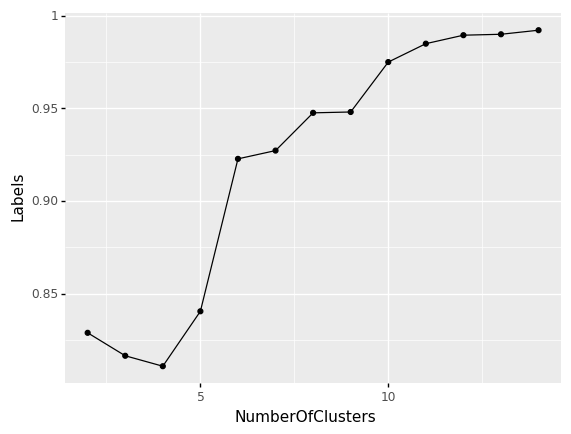

<ggplot: (190967443725)>

In [76]:
silhouettes = []

for i in range(2,15,1):
  model = KMeans(n_clusters=i)
  aux = all_the_queens_wasps_TRAIN.loc[all_the_queens_wasps_TRAIN.year_offset == 2018, ['fv_size_small', 'fv_size_mid', 'fv_size_large', 'fv_type_natural', 'fv_type_urban', 'fv_status_cantkill', 'fv_status_dead', 'fv_status_pending']]
  model.fit(aux)
  labels = model.labels_
  sol = silhouette_score(aux, labels)
  silhouettes.append(sol)

silhouette = pd.DataFrame()
silhouette['Labels'] = silhouettes
silhouette['NumberOfClusters'] = range(2,15,1)

ggplot(aes(x='NumberOfClusters', y='Labels'), silhouette) + geom_line() + geom_point()

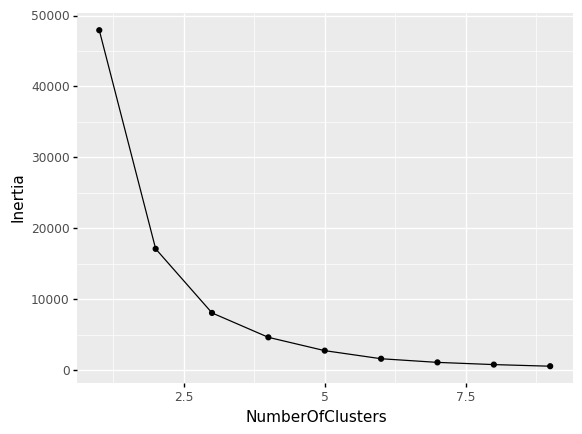

<ggplot: (190968667495)>

In [68]:
inertias = []
for i in range(1,10,1):
  model = KMeans(n_clusters=i)
  aux = all_the_queens_wasps_TRAIN.loc[all_the_queens_wasps_TRAIN.year_offset == 2018, ['fv_size_small', 'fv_size_mid', 'fv_size_large', 'fv_type_natural', 'fv_type_urban', 'fv_status_cantkill', 'fv_status_dead', 'fv_status_pending']]
  model.fit(aux)
  inertias.append(model.inertia_)

elbow = pd.DataFrame()
elbow['Inertia'] = inertias
elbow['NumberOfClusters'] = range(1,10,1)

ggplot(aes(x='NumberOfClusters', y='Inertia'), elbow) + geom_line() + geom_point()

### Exploring clustering of weather variables (`weath_`)

In [69]:
# scale the dataset using MinMaxScaler, the most common approach

scalators = ['weath_days_frost', 'weath_humidity', 'weath_maxLevel', 'weath_midLevel', 'weath_minLevel', 'weath_days_rain', 'weath_days_rain1mm', 'weath_accuRainfall', 'weath_10minRainfall', 'weath_1dayRainfall', 'weath_solar', 'weath_meanTemp', 'weath_maxTemp', 'weath_maxMeanTemp', 'weath_minTemp', 'weath_meanWindM', 'weath_maxWindM', 'weath_meanDayMaxWind']
all_the_queens_wasps_TRAIN[scalators] = preprocessing.minmax_scale(all_the_queens_wasps_TRAIN[scalators])

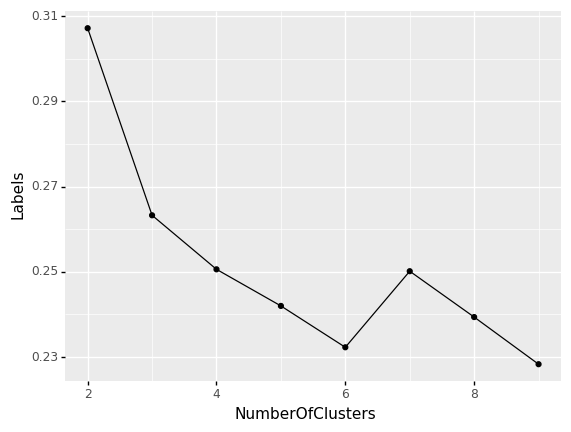

<ggplot: (190969282862)>

In [70]:
silhouettes = []

for i in range(2,10,1):
  model = KMeans(n_clusters=i)
  aux = all_the_queens_wasps_TRAIN.loc[all_the_queens_wasps_TRAIN.year_offset == 2018, ['weath_days_frost', 'weath_humidity', 'weath_maxLevel', 'weath_midLevel', 'weath_minLevel', 'weath_days_rain', 'weath_days_rain1mm', 'weath_accuRainfall', 'weath_10minRainfall', 'weath_1dayRainfall', 'weath_solar', 'weath_meanTemp', 'weath_maxTemp', 'weath_maxMeanTemp', 'weath_minTemp', 'weath_meanWindM', 'weath_maxWindM', 'weath_meanDayMaxWind']]
  model.fit(aux)
  labels = model.labels_
  sol = silhouette_score(aux, labels)
  silhouettes.append(sol)

silhouette = pd.DataFrame()
silhouette['Labels'] = silhouettes
silhouette['NumberOfClusters'] = range(2,10,1)

ggplot(aes(x='NumberOfClusters', y='Labels'), silhouette) + geom_line() + geom_point()

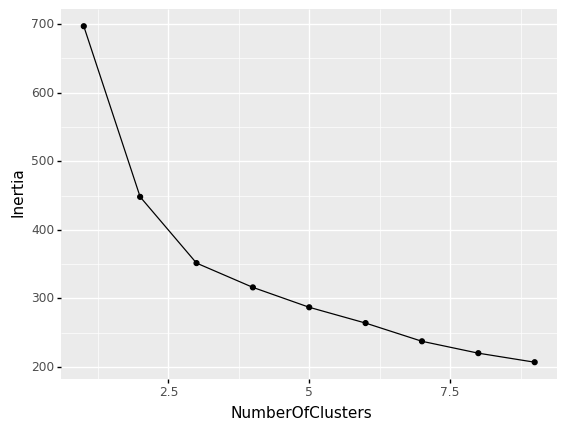

<ggplot: (190969406341)>

In [71]:
inertias = []
for i in range(1,10,1):
  model = KMeans(n_clusters=i)
  aux = all_the_queens_wasps_TRAIN.loc[all_the_queens_wasps_TRAIN.year_offset == 2018, ['weath_days_frost', 'weath_humidity', 'weath_maxLevel', 'weath_midLevel', 'weath_minLevel', 'weath_days_rain', 'weath_days_rain1mm', 'weath_accuRainfall', 'weath_10minRainfall', 'weath_1dayRainfall', 'weath_solar', 'weath_meanTemp', 'weath_maxTemp', 'weath_maxMeanTemp', 'weath_minTemp', 'weath_meanWindM', 'weath_maxWindM', 'weath_meanDayMaxWind']]
  model.fit(aux)
  inertias.append(model.inertia_)

elbow = pd.DataFrame()
elbow['Inertia'] = inertias
elbow['NumberOfClusters'] = range(1,10,1)

ggplot(aes(x='NumberOfClusters', y='Inertia'), elbow) + geom_line() + geom_point()

### Exploring clustering of food variables (`food_`)

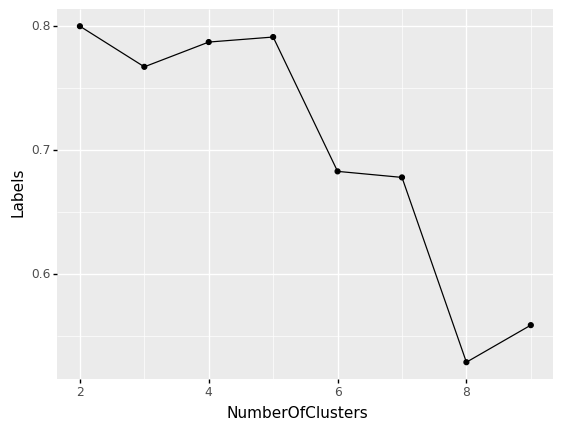

<ggplot: (190969358306)>

In [72]:
silhouettes = []

for i in range(2,10,1):
  model = KMeans(n_clusters=i)
  aux = all_the_queens_wasps_TRAIN.loc[all_the_queens_wasps_TRAIN.year_offset == 2018, ['colonies_amount', 'food_fruit', 'food_apple', 'food_txakoli', 'food_kiwi', 'food_pear', 'food_blueberry', 'food_raspberry']]
  model.fit(aux)
  labels = model.labels_
  sol = silhouette_score(aux, labels)
  silhouettes.append(sol)

silhouette = pd.DataFrame()
silhouette['Labels'] = silhouettes
silhouette['NumberOfClusters'] = range(2,10,1)

ggplot(aes(x='NumberOfClusters', y='Labels'), silhouette) + geom_line() + geom_point()

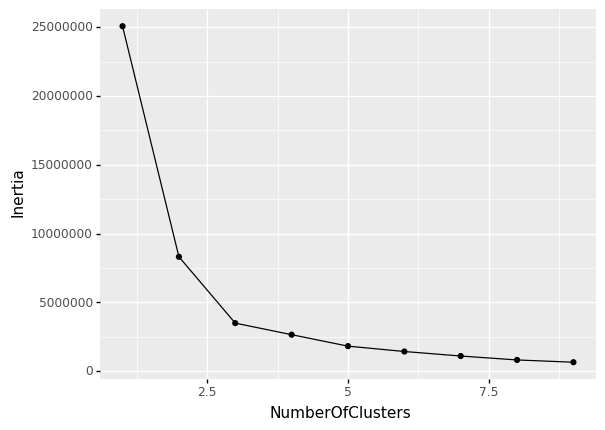

<ggplot: (190969292216)>

In [73]:
inertias = []
for i in range(1,10,1):
  model = KMeans(n_clusters=i)
  aux = all_the_queens_wasps_TRAIN.loc[all_the_queens_wasps_TRAIN.year_offset == 2018, ['colonies_amount', 'food_fruit', 'food_apple', 'food_txakoli', 'food_kiwi', 'food_pear', 'food_blueberry', 'food_raspberry']]
  model.fit(aux)
  inertias.append(model.inertia_)

elbow = pd.DataFrame()
elbow['Inertia'] = inertias
elbow['NumberOfClusters'] = range(1,10,1)

ggplot(aes(x='NumberOfClusters', y='Inertia'), elbow) + geom_line() + geom_point()

### How many clusters do we need?

In [75]:
#silhouette_output = 

### Cluster up

In [ ]:
model = KMeans(n_clusters = silhouette_output)

aux = all_the_queens_wasps_TRAIN.loc[:,['Defense', 'Attack', 'Speed']]
model.fit(aux)
modelLabels = model.labels_
modelCenters = model.cluster_centers_

all_the_queens_wasps_TRAIN['Cluster'] = pd.Series(modelLabels, index=all_the_queens_wasps_TRAIN.index)

In [ ]:
clusters_table = all_the_queens_wasps_TRAIN.groupby('Cluster').mean()
pd.value_counts(all_the_queens_wasps_TRAIN.Cluster)

In [ ]:
clusters_table.drop(columns=['Id'], inplace=True)
clusters_table

In [ ]:
clusters_table.to_excel("/Kopuru-VespaVelutina-Clustering.xlsx", index=False)

## Final check

In [ ]:
all_the_queens_wasps.isnull().sum()

In [ ]:
# check how many rows (municipalities) are there in the dataframe for each year/month combination
pd.crosstab(all_the_queens_wasps.year_offset, all_the_queens_wasps.month)

In [ ]:
# this loops helps verify which municipality may be missing from any given year/month combination
for i in range(1,13,1):
    print(df01.municip_code[~df01.municip_code.isin\
                  (all_the_queens_wasps.loc[(all_the_queens_wasps.month == i) &\
                                            (all_the_queens_wasps.year_offset == 2019),:].\
                   municip_code.unique())])

In [ ]:
all_the_queens_wasps_TRAIN.NESTS.sum() == df02_vespas.shape[0]

In [ ]:
all_the_queens_wasps_PREDICT.NESTS.sum() == 0

## Export the TRAINING dataset for the model
A dataset which relates the weather from a previous year (12 months ago) to an amount of NESTS in any given year (and month).

In [61]:
all_the_queens_wasps_TRAIN.to_csv('WBds03_QUEENtrainMONTHS.csv', index=False)

## Export the PREDICTION dataset for the model

In [62]:
all_the_queens_wasps_PREDICT.to_csv('WBds03_QUEENpredictMONTHS.csv', index=False)